In [1]:
%matplotlib inline
from IPython.display import YouTubeVideo

# Preface

Now we will learn about the best practices of building good machine learning models by fine-tuning the algorithms and evaluating the model's performance.  In this chapter, we will learn how to do the following:
1. Obtain unbiased estimates of a model's performance
2. Diagnose the common problems of machine learning algorithms.
3. Fine-tune machine learning algorithms.
4. Evaluate the predictive models using different performance metrics.

## Loading the Breast Cancer Wisconsin dataset

In this chapter, we will be working with the Breast Cancer Wisconsin dataset, which contains 569 samples of malignant and benign tumor cells.  The first two columns in the dataset store the unique ID numbers of the samples and corresponding diagnoses (```M``` = malignant, ```B``` = benign), respectively.  Columns 3-32 contain 30 real-valued features that have been computed from digitised images of the cell nuclei, which can be used to build a model to predict whether a tumor is benign or malignant.

The Breast Cancer Wisconsin dataset has been deposited in the UCI Machine Learning Repository, and more detailed information about this dataset can be found at:  ```https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+(Diagnostic).```

In this section, we will read in the dataset and split it into training and test datasets in three simple steps:

1) First we start by reading in the dataset from my hard-drive using pandas:

In [2]:
import pandas as pd
df = pd.read_csv("/home/henri/stuff/machine_learning/sebastian_raschka/henris_coding/chapter_06/wdbc.data", header=None)

2) Next, we assing the 30 features to a NumPy array ```X```.  Using a ```LabelEncoder``` object, we transform the class labels from their original string representation ('M' and 'B') into integers:

In [3]:
from sklearn.preprocessing import LabelEncoder

X = df.loc[:, 2:].values
y = df.loc[:, 1].values

le = LabelEncoder()
y = le.fit_transform(y)
le.classes_

array(['B', 'M'], dtype=object)

After encoding the class labels (diagnosis) in an array ```y```, the malignant tumors are now represented as class ```1```, and the benign tumors are represented as class ```0```, respectively.  We can double-check this mapping by calling the ```transform``` metod of the fitted ```LabelEncoder``` on two dummy class labels:

In [4]:
le.transform(['M', 'B'])

array([1, 0])

3) Before we construct our first model pipeline in the following subsection, let us divide the dataset into a separate dataset (80 percent of the data) and a separate dataset (20 percent of the data):

In [5]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, stratify=y, random_state=1)

## Combining transformers and estimators in a pipeline.

Instead of going through the fitting and transformation steps for the training and test datasets separately, we can chain the ```StandardScaler,PCA``` and ```LogisticRegression``` objects into a pipeline:

In [6]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline

pipe_lr = make_pipeline(StandardScaler(),
                        PCA(n_components=2),
                        LogisticRegression(random_state=1))
pipe_lr.fit(X_train, y_train)
y_pred = pipe_lr.predict(X_test)
print("Test Accuracy: {:.3f}".format(pipe_lr.score(X_test, y_test)))

Test Accuracy: 0.956


The ```make_pipeline``` function takes an arbitrary number of scikit-learn transformers (objects that support the ```fit``` and ```transform``` methods as input), followed by a scikit-learn estimator that implements the ```fit``` and ```predict``` methods.

We can think of a scikit-learn ```Pipeline``` as a meta-estimator or wrapper around those individual transformers and estimators.

There is no limit to the number of intermediate steps in a pipeline; however, the last pipeline element has to be an estimator.  Pipelines also implement a ```predict``` method.  In the final step, the estimator object will then return a prediction on the transformed data.

Let us take a close look at the following illustration, which summarises the concept of pipelines as discussed in this section.

<img src="images/06_01.png" alt="sklearn_pipeline" style="width: 500px;"/>

# Using the k-fold cross-validation to assess the model performance.

To find an acceptable bias-variance trade-off, we need to evaluate our model carefully.  In this section, we will learn about the common cross-validation techniques **holdout cross-validation** and **k-fold cross-validation**, which can help to obtain reliable estimates of the model's generalisation performance, that is, how well the model performs on unseen data.

## The holdout method

Using the holdout method, we split our initial dataset into separate training and test datasets - the former is used for model training, and the latter is used to estimate its generalisation performance.

In **model selection**, we want to select the _optimal_ values of the tuning parameters (also called the hyperparameters).  However, if we reuse the same test dataset over and over again during the model selection, it will become part or our training data and thus the model will be more likely to overfit.

A better way of using the holdout method for model selection is to separate the data into 3 parts:  a training set, a validation set, and a test set.  The training set is used to fit the different models, and the performance on the validation set is then used for the model-selection.  The advantage of having a test set that the model has not seen before during the training and model selection steps is that we can obtain a less biased estimate of its ability to generalise to new data.

<img src="images/06_02.png" alt="holdout_method" style="width: 500px;"/>

A disadvantage of the holdout method is that the performance estimate may be very senstive to how we partition the traiing set into the training and validation subsets; the estimate will vary for different samples of the data.

## K-fold cross-validation

In k-fold cross-validation we randomly split the traiing dataset into $k$ folds without replacement, where $k-1$ folds are used for the model training, and the one fold is used for performance evaluation.  The procedure is repeated $k$ times so that we obtain k models and performance estimates.

We then calculate the average performance of the models based on the different independent folds to obtain a performance estimate that is les sensitive to the sub-partitioning of the training data cmpared to the holdout method.  Typically, we use k-fold cross-validation for model tuning, that is, finding the optimal hyperparameter values that yields a satisfying generalisation performance.

Once we have found satisfactory hyperparameter values, we can retrain the model on the complete training set and obtain a final performance estimate using the independent test set.  The rationale behind fitting a model to the whole training dataset after k-fold cross-validation is that providing more training samples to a learning algorithm usually results in a more accurate and robust model.

The advantange of this approach is that each sample point will be used for training and validation (as part of a test fold) exactly once, whihc yields a lower-variance estimate of the model performance than the holdout method.

The following figure summarises the concept behind k-fold cross-validation with $k=10$.  The training dataset is divided into 10 folds, and during the 10 iterations, nine folds are used for training, and one fold will be used as the test set for the model evaluation.  Also, the estimated performances $E_i$ for each fold are then used to calculate the estimated average performance $E$ of the model:

<img src="images/06_03.png" alt="k_fold_cross_validation" style="width: 500px;"/>

A slight improvement over the standard k-fold cross-validation approach is stratified k-fold cross-validation, which can yield better bias and variance estimates, especially in cases of unequal class proportions, as has been shown in a study by Ron Kohavi.  In stratified cross-validation, the class proportions are preserved in each fold to ensure that each fold is representative of the class proportions in the training dataset, which we will illustrate by using the ```StratifiedKFold``` iterator in scikit-learn:

In [7]:
import numpy as np
from sklearn.model_selection import StratifiedKFold

kfold = StratifiedKFold(n_splits=10, random_state=1).split(X_train, y_train)

scores = []

for k, (train, test) in enumerate(kfold):
    pipe_lr.fit(X_train[train], y_train[train])
    score = pipe_lr.score(X_train[test], y_train[test])
    scores.append(score)
    print("Fold: {:2d}, Class Distribution: {}, Accuracy: {:.3f}".format(k+1, np.bincount(y_train[train]), score))
    
print("\nCV accuracy: {:.3f} +/- {:.3f}".format(np.mean(scores), np.std(scores)))

print("\nWe should keep in mind that:")
print("X.shape[0] x 0.80 = {} x 0.80 = {:.0f}.".format(X.shape[0], X.shape[0]*0.80))
print("And therefore:")
print("455 - 455/10 = 409")
print("256 + 153 = 409")
print("\nProportions:  256/409 = {:.3f} AND 153/409 = {:.3f}".format(256.0/409.0,  153/409))
print("\nOriginal Proportions (0): {:.3f}".format(len(y_train[y_train==0])/len(y_train)))
print("Original Proportions (1): {:.3f}".format(len(y_train[y_train==1])/len(y_train)))


Fold:  1, Class Distribution: [256 153], Accuracy: 0.935
Fold:  2, Class Distribution: [256 153], Accuracy: 0.935
Fold:  3, Class Distribution: [256 153], Accuracy: 0.957
Fold:  4, Class Distribution: [256 153], Accuracy: 0.957
Fold:  5, Class Distribution: [256 153], Accuracy: 0.935
Fold:  6, Class Distribution: [257 153], Accuracy: 0.956
Fold:  7, Class Distribution: [257 153], Accuracy: 0.978
Fold:  8, Class Distribution: [257 153], Accuracy: 0.933
Fold:  9, Class Distribution: [257 153], Accuracy: 0.956
Fold: 10, Class Distribution: [257 153], Accuracy: 0.956

CV accuracy: 0.950 +/- 0.014

We should keep in mind that:
X.shape[0] x 0.80 = 569 x 0.80 = 455.
And therefore:
455 - 455/10 = 409
256 + 153 = 409

Proportions:  256/409 = 0.626 AND 153/409 = 0.374

Original Proportions (0): 0.626
Original Proportions (1): 0.374


Although the previous code example was useful to illustrate how k-fold cross valiation wordks, scikit-learn also implements a k-fold corss-validation scorer, which allows us to evaluate our model using stratified k-fold cross-validation less verbosely.

In [8]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(estimator=pipe_lr,
                        X=X_train,
                        y=y_train,
                        cv=10,
                        n_jobs=-1)
print("CV accuracy scores: {}".format(scores))
print("CV accuracy: {:.3f} +/- {:.3f}".format(np.mean(scores), np.std(scores)))

CV accuracy scores: [0.93478261 0.93478261 0.95652174 0.95652174 0.93478261 0.95555556
 0.97777778 0.93333333 0.95555556 0.95555556]
CV accuracy: 0.950 +/- 0.014


An extremely useful feature of the ```cross_val_score``` approach is that we can distribute the evaluation of the different folds accross multiple CPUs on our machine.

# Diagnosing bias and variance problems with learing curves

<img src="images/06_04.png" alt="Bias_vs_Variance" style="width: 500px;"/>
The graph in the upper-left shows a model with high bias.  This model has both low training and cross-validation accuracy, which indicates that it underfits the training data.  Common ways to address this issue are to increase the number of parameters of the model, for example, by collectin gor constructing additional features or by decreasing the degree of regulrisation, for example, in SVM or logistic regression classifiers.

The graph in the upper-right shows a model that suffers from high variane, which is indiated by the large gap between the training and cross-validation accuracy.  To address this problem of overfitting, we can collect more training data, reduce the complexity of the model, or increase the regularisation parameter, for example.  For unregularised models, it can also help to decrease the number of features via feature selection or feature extraction.  Collecting more training samples may not always help though, for example, if the training data is extremely noisy or the model is already very close to optimal.

Let us first see how we can use the learing curve function from scikit-learn to evaluate the model:

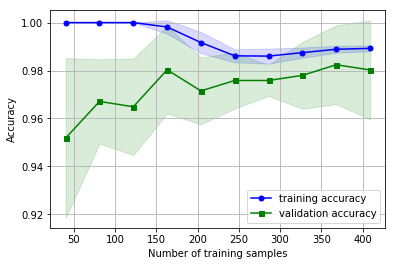

In [9]:
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve

pipe_lr = make_pipeline(StandardScaler(), LogisticRegression(penalty='l2', random_state=1))

train_sizes, train_scores, test_scores = learning_curve(estimator=pipe_lr,
                                                      X=X_train,
                                                      y=y_train,
                                                      train_sizes=np.linspace(0.1,1.0,10),
                                                      cv=10,
                                                      n_jobs=-1)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='training accuracy')
plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')

plt.plot(train_sizes, test_mean, color='green', marker='s', markersize=5, label='validation accuracy')
plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std, alpha=0.15, color='green')

plt.grid()
plt.xlabel("Number of training samples")
plt.ylabel("Accuracy")
plt.legend(loc="lower right")
plt.show()

Via the ```train_sizes``` parameter in the ```learing_curve``` function, we can control the absolute or relative number of training samples that are used to generate the learning curves.

By default, the ```learning_curve``` function uses the stratified k-fold cross-validation to calculate the cross-validation accuracy of a classifier.

```fill_between``` indicates the variances of the estimates.

As we can see in the preceding learning curve plot, our model performs quite well on both the training and validation dataset if it had seen more than 250 samples during training.  We can also see that the training accuracy increases for traiing sets with fewer than 250 samples, and the gp between validation and training accuracy widens, and indicator of an increasing degree of overfitting.

# Addressing over- and under-fitting with validation curves

In validation curves, we vary the values of the model parameters, for example the inverse regularisation parameter ```C``` in logistic regression.  Let's go ahead and see how we create the validation curves via scikit-learn:

Train scores:
[[0.94132029 0.93398533 0.94132029 0.93887531 0.94376528 0.94146341
  0.94146341 0.94390244 0.94146341 0.93902439]
 [0.97310513 0.97066015 0.97066015 0.96821516 0.97799511 0.97560976
  0.97317073 0.96585366 0.97073171 0.97073171]
 [0.98533007 0.98533007 0.98533007 0.98288509 0.98777506 0.98780488
  0.98780488 0.98292683 0.98536585 0.98536585]
 [0.98777506 0.98777506 0.99022005 0.99022005 0.99022005 0.9902439
  0.9902439  0.98780488 0.9902439  0.98780488]
 [0.98533007 0.98777506 0.98533007 0.99266504 0.99266504 0.9902439
  0.9902439  0.98780488 0.9902439  0.98780488]
 [0.99022005 0.99022005 0.99022005 0.99511002 1.         0.9902439
  0.9902439  0.99512195 0.99268293 0.98780488]]

Test scores:
[[0.93478261 0.93478261 0.93478261 0.95652174 0.86956522 0.93333333
  0.97777778 0.93333333 0.95555556 0.97777778]
 [0.93478261 0.97826087 0.97826087 0.97826087 0.93478261 0.95555556
  0.97777778 1.         0.97777778 1.        ]
 [0.97826087 1.         0.97826087 0.95652174 0.956521

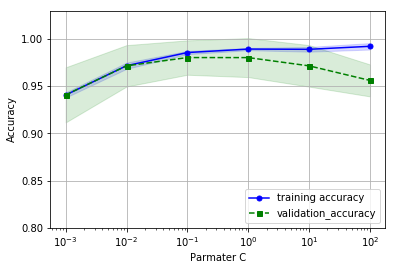

In [10]:
from sklearn.model_selection import validation_curve
param_range = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]
train_scores, test_scores = validation_curve(estimator=pipe_lr,
                                            X=X_train,
                                            y=y_train,
                                            param_name='logisticregression__C',
                                            param_range=param_range,
                                            cv=10,
                                            n_jobs=-1)
print("Train scores:\n{}".format(train_scores))
print("\nTest scores:\n{}".format(test_scores))

train_mean = np.mean(train_scores, axis=1)  # hop over the columns to get the mean
train_std = np.std(train_scores, axis=1)

test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(param_range, train_mean, color='blue', marker='o', markersize=5, label='training accuracy')
plt.fill_between(param_range, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')

plt.plot(param_range, test_mean, color='green', linestyle='--', marker='s', markersize=5, label='validation_accuracy')
plt.fill_between(param_range, test_mean + test_std, test_mean - test_std, alpha=0.15, color='green')

plt.grid()
plt.xscale('log')
plt.legend(loc='lower right')
plt.xlabel('Parmater C')
plt.ylabel('Accuracy')
plt.ylim([0.8, 1.03])
plt.show()

Although the differences in the accuracy for the varying values of ```C``` are subtle, we can see that the model slightly underfits the data when we increase the regularisation strength (small values of ```C```).  However, for large values of ```C```, it means lowering the strength of regularisation, so the model slightly overfits the data.  In this case the sweet appears to be between ```0.01``` and ```0.1``` of the ```C``` value.

# Tuning hyperparameters via grid search

The approach of the grid search is quite simple; it's a brute-force exhaustive search paradigm where we specify a list of values for different hyperparameters, and the computer evaluates the model performance for each possible combination of those to obtain the optimal combination of values from this set:

In [11]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

pipe_svc = make_pipeline(StandardScaler(),
                        SVC(random_state=1))
param_range = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]
param_grid = [{'svc__C': param_range,
              'svc__kernel': ['linear']},
              {'svc__C': param_range,
              'svc__gamma': param_range,
              'svc__kernel': ['rbf']}]
# C: Penalty parameter C of the error term.
# gamma: kernel coefficient for 'rbf'.
# C-support vector classification.

gs = GridSearchCV(estimator=pipe_svc,
                 param_grid=param_grid,
                 scoring='accuracy',
                 cv=10,
                 n_jobs=-1)

gs = gs.fit(X_train, y_train)
print(gs.best_score_)

print(gs.best_params_)

0.9846153846153847
{'svc__C': 100, 'svc__gamma': 0.001, 'svc__kernel': 'rbf'}


Finally, we will use the independent test dataset to estimate the performance of the best-selected model, wich is available via the ```best_estimator_``` attribute of the ```GridSearchCV``` object:

In [12]:
clf = gs.best_estimator_
clf.fit(X_train, y_train)
print("Test Accuracy: {:.3f}".format(clf.score(X_test, y_test)))

Test Accuracy: 0.974


# Algorithm Selection with Nested Cross-Validation

If we want to select among different machine learning algorithms, though, another recommended approach is nested cross-validation.

In nested cross-validation, we have an outer k-fold cross validation loop to split the data into training and test folds, and an inner loop is used to select the model using k-fold cross-validation on the training fold.  After model selection, the test fold is then used to evaluate the model performance.

The following figure explains the concept of nested cross-validation with only five outer and two inner folds.  This particular type of nested cross-validation is also known as **5x2 cross validation**
<img src="images/06_07.png" alt="nested_cv" style="width: 500px;"/>

In scikit-learn, we can perform nested cross-validation as follows:

In [13]:
gs = GridSearchCV(estimator=pipe_svc,
                 param_grid=param_grid,
                 scoring="accuracy",
                 cv=2)

scores = cross_val_score(gs, X_train, y_train,
                        scoring="accuracy", cv=5)
print("CV accuracy: {:.3f} +/- {:.3f}".format(np.mean(scores), np.std(scores)))

CV accuracy: 0.974 +/- 0.015


The returned average cross-validation accuracy gives us a good estimate of what to expect if we tune the hyperparameters of a model and us it on unseen data.  Fo example, we can use the nested cross-validation approach to compare an SVM model to a simple decision tree classifier; for simplicity we will only tune its depth parameter:

In [14]:
from sklearn.tree import DecisionTreeClassifier

gs = GridSearchCV(estimator=DecisionTreeClassifier(random_state=0),
                 param_grid=[{"max_depth": [1,2,3,4,5,6,7,None]}],
                 scoring="accuracy",
                 cv=2)

scores = cross_val_score(gs, X_train, y_train,
                       scoring="accuracy",
                       cv=5)

print("CV accuracy: {:.3f} +/- {:.3f}".format(np.mean(scores), np.std(scores)))

CV accuracy: 0.934 +/- 0.016


As we can see, the nested cross-validation performance of the SVM model (97.4 percent) is notably better than the performance of the decision tree (93.4 percent), and thus, we'd expect that it might be the better choice to classify new data that comes from the same population as this particular dataset.

# Looking at different performance evluation metrics.

However, there are several other performance metrics that can be used to measure a model's revelance, such as precision, recall, and the F1-score.

## Reading a confusion matrix
A confusion matrix is a matrix that lays out the performance of a learning algorithm.  It is simply a squre matrix that reports the counts of the True Positive (TP), True Negative (TN), False Positive (FP), and False Negative (FN) predictions of a classifier, as shown in the following figure:
<img src="images/06_08.png" alt="confusion_matrix" style="width: 500px;"/>

Although these metrics can be easily computed manually by comparing the true and predicted class labels, scikit-learn provices a convenient confusion_matrix function that we can use as follows:

In [15]:
from sklearn.metrics import confusion_matrix

pipe_svc.fit(X_train, y_train)
y_pred = pipe_svc.predict(X_test)
confmat = confusion_matrix(y_true=y_test, y_pred=y_pred)
print(confmat)

[[71  1]
 [ 2 40]]


The array that was returned after executing the code provides us with information about the different types of error the classifier made on the test dataset.  We can mapt this information onto the confusion matrix illustration in the previous figure using Matplotlib's ```matshow``` function:

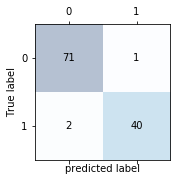

In [16]:
fig, ax = plt.subplots(figsize=(2.5, 2.5))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i, s=confmat[i, j],
               va='center', ha='center')
plt.xlabel('predicted label')
plt.ylabel('True label')
plt.show()

Assuming that class 1 (malignant) is the positive class in this example, our model correctly classified 71 of the samples that belong to class 0 (TNs) and 40 samples that belong to class 1 (TPs), respectively.  However, our model also incorrectly misclassified two samples from class 1 as class 0 (FN), and it predicted that one sample is malignant although it is a beign tumor (FP).  In the next section, we will learn how we can use this information to calculate various error metrics.

# Optimising the precision and recall of a classification model.

Error can be userstood as the sum of all false predictions divided by the number of total predictions, and the accuracy is calculated as the sum of correc predictions divided by the total number of predictions, respectively:
$$
ERR = \frac{FP+FN}{FP+FN+TP+TN}
$$
The prediction accuracy can then be calculated directly from the error:
$$
ACC = \frac{TP+TN}{FP+FN+TP+TN} = 1 - ERR
$$

The True Positive Rate and False Positive Rate are performance metrics that are especially useful for imbalanced class problems:
$$
FPR = \frac{FP}{N} = \frac{FP}{FP + TN}
$$
$$
TPR = \frac{TP}{P} = \frac{TP}{FN + TP}
$$

In rumor diagnosis, for example, we are more concerned about the detection of malignant tumors in order to help a patient with the appropriate treatment.  However, it is also important to decrease the number of benign tumors that were incorrectly classified as malignant (FPs) to no unnecessarily concern a patient.

In contrast to FPR, TPR provides useful information about the fraction of positive (or relevant) samples that were correctly identified out of the total pool of positives (P).

The performance metrics **precision (PRE)**, and **recall (REC)** are related to those true positive and negative rates, and in fact, REC is synonymous with TPR:
$$
PRE = \frac{TP}{TP + FP}
$$
$$
REC = TPR = \frac{TP}{P} = \frac{TP}{FN + TP}
$$

In practice, often a combination of the PRE and REC is used, the so-called **F1-Score**
$$
F1 = 2\frac{PRE\times REC}{PRE + REC}
$$
Those scoring metrics are all implemented in scikit-learn and can be imported from ```sklearn.metrics``` module as shown in the following snippet:

In [17]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score, f1_score

print("Precision: {:.3f}, Recall: {:.3f}, F1: {:.3f}.".format(precision_score(y_true=y_test,
                                                                              y_pred=y_pred),
                                                 recall_score(y_true=y_test,
                                                              y_pred=y_pred),
                                                 f1_score(y_true=y_test,
                                                          y_pred=y_pred)))

Precision: 0.976, Recall: 0.952, F1: 0.964.


Remember that the positive class in scikit-learn is the class that is labeled as class 1.  If we want to specify a different _positive label_, we can construct our own scorer via the ```make_scorer``` function, which we can then directly provide as an argument to the scoring paramemter in ```GridSearchCV``` (in this example, using the ```f1_score``` as a metric):

In [18]:
from sklearn.metrics import make_scorer, f1_score
scorer = make_scorer(f1_score, pos_label=0)
gs = GridSearchCV(estimator=pipe_svc,
                 param_grid=param_grid,
                 scoring=scorer,
                 cv=10)
fs = gs.fit(X_train, y_train)
print(gs.best_score_)
print(gs.best_params_)

0.9880219137963148
{'svc__C': 100, 'svc__gamma': 0.001, 'svc__kernel': 'rbf'}


# Plotting a Receiver Operating Characteristic

ROC graphs are useful tools to select models for classification based on their performance with respect to the FPR and TPR, which are computed by shifting the decision threshold of the classifier.  The diagonal of an ROC graph can be interpreted as _random guessing_, and classification models that fall below the diagonal are considered worse than random guessing.  A perfect classifier would fall into the top left corner of the graph with a TPR of 1 and an FPR of 0.  Based on the ROC curve, we can then compute the so-called ROC Area Under the Curve (ROC AUC) to characterize the performance of a classification model.

Execuitng the following code example, we will plot an ROC curve of a classifier that only uses 2 features from the Breast Cancer Wisconsin dataset to predict whether a tumor is bening or malignant.  Although we are going to use the same logisitic regression pipeline that we defined previously, we are making the classification task more challenging for the classifier so that the resulting ROC curve becomes visually more interesting.  For similar reasons, we are also reducing the number of folds in the ```StratifiedKFold``` validator to 3.  The code is as follows:

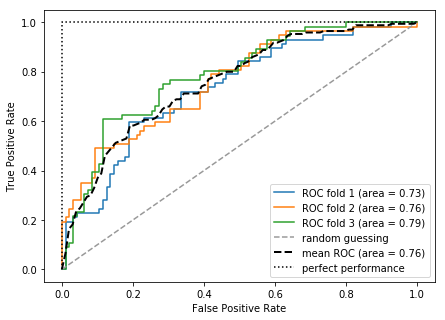

In [26]:
from sklearn.metrics import roc_curve, auc
from scipy import interp

pipe_lr = make_pipeline(StandardScaler(),
                       PCA(n_components=2),
                       LogisticRegression(penalty='l2',
                                         random_state=1,
                                         C=100.0))

X_train2 = X_train[:, [4, 14]]
cv = list(StratifiedKFold(n_splits=3,
                         random_state=1).split(X_train,
                                              y_train))
# cv is a list of 2-element tuples.  There are 3 tuples stored in this list.
# The first element of each tuple contains the train indices
# The second element of each tuple contains the test indices

fig = plt.figure(figsize=(7, 5))
mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)
all_tpr = []

for i, (train, test) in enumerate(cv):
    probas = pipe_lr.fit(X_train2[train], y_train[train]).predict_proba(X_train2[test])
    fpr, tpr, thresholds = roc_curve(y_train[test],
                                    probas[:, 1],
                                    pos_label=1)
    mean_tpr += interp(mean_fpr, fpr, tpr)
    mean_tpr[0] = 0.0
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label="ROC fold {:d} (area = {:.2f})".format(i+1, roc_auc))
    
plt.plot([0,1], [0,1], linestyle="--", color=(0.6,0.6,0.6), label="random guessing")

mean_tpr /= len(cv)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, 'k--', label="mean ROC (area = {:.2f})".format(mean_auc), lw=2)

plt.plot([0,0,1], [0,1,1], linestyle=':', color='black', label="perfect performance")

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()

The resulting ROC curve indicates there is a certain degree of variance between the different folds, and the average ROC (0.76) falls between the perfect score (1.0) and random guessing (0.5).

Note that if we are just interested in the ROC AUC score, we could also directly import the ```roc_auc_score``` function from the ```sklearn.metrics``` submodule.

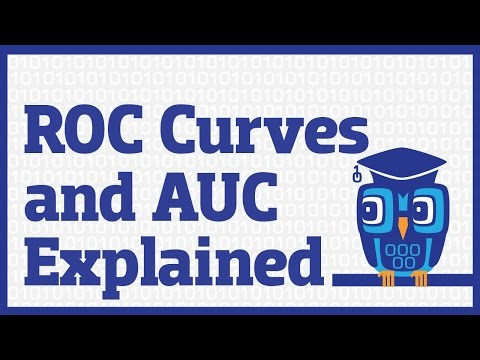

In [20]:
YouTubeVideo('OAl6eAyP-yo')

# Scoring metrics for multiclass classification

Scikit-learn also implements macro and micro averaging methods to extend those scoring metrics to multiclass problems via (One-versus-All) classification.  The micro-averaging is calculated from the individual TPs, TNs, FPs, and FNs of the system.  For example, the micro-average of the precision score in a k-class system can be calculated as follows:
$$
PRE_{micro} = \frac{TP_1 + \cdot\cdot\cdot + TP_k}{TP_1 + \cdot\cdot\cdot + TP_k + FP_1 + \cdot\cdot\cdot + FP_k}
$$
The macro average is simply calculated as the average scores of the different systems:
$$
PRE_{macro} = \frac{PRE_1 + \cdot\cdot\cdot + PRE_k}{k}
$$

Micro-averaging is useful if we want to weigh each instance of prediction equally, whereas macro-averaging weighs all classes equally to evaluate the overall performance of a classifier with regard to the most frequent class labels.

If we are using binary performance metrics to evaluate multiclass classification models in scikit-learn, a normalised or weighted variant of the macro-average is used by default.  The weighted macro-average is calculated by weighing the score of each class label by the number of true instances when calculating the average.  The weighted macro-average is useful if we are dealing with class imbalances, that is, different numbers of instaces for each label.

While the weighted macro-average is the default for multiclass problems in scikit-learn, we can specify the averaging method via the ```average``` parameter inside the different scoring functions that we import from the ```sklearn.metrics``` module, for example, the ```precision_score``` or ```make_scorer``` functions:

In [21]:
pre_scorer = make_scorer(score_func=precision_score,
                        pos_label=1,
                        greater_is_better=True,
                        average='micro')

# Dealing with class imbalance

One way to deal with imbalanced class proportions during the model fitting is to assign a larger penalty to wrong predictions on the minority class.  Via sciki-learn, adjusting such a penalty is as convenient as setting the ```class_weight``` parameter to ```class_weight='balanced'```, which is implemented for most classifiers.

Other popular strategies for dealing with class imblance include upsampling the minority class, downsampling the majority class, and the generation of synthetic training samples.

The scikit-learn implements a simple ```resample``` function that can help with the upsiampling of the minority class by drawing new samples from the dataset with replacement.  The following code will tae the minority class from our imbalanced breast cancer dataset (here, class 1) and repeatedly draw new sample from it until it contains the same number of samples as class label 0:

In [28]:
X_imb = np.vstack((X[y==0], X[y==1][:40]))
y_imb = np.hstack((y[y==0], y[y==1][:40]))
print("y_imb:\n{}".format(y_imb))

from sklearn.utils import resample

print("Number of class 1 samples before: {}".format(X_imb[y_imb==1].shape[0]))

X_upsampled, y_upsampled = resample(X_imb[y_imb==1],
                                   y_imb[y_imb==1],
                                   replace=True,
                                   n_samples=X_imb[y_imb==0].shape[0],
                                   random_state=123)

print("Number of class 1 samples after: {}".format(X_upsampled[y_upsampled==1].shape[0]))

y_imb:
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Number of class 1 samples before: 40
Number of class 1 samples after: 357


After resampling, we can then stack the original class 0 samples with the upsampled class 1 subset to obtain a balanced dataset as follows:

In [23]:
X_bal = np.vstack((X[y==0], X_upsampled))
y_bal = np.hstack((y[y==0], y_upsampled))

Similarly, we could downsample the majority class by removing training examples from the dataset.  To perform downsampling using the resample function, we could simply swap the class 1 label with class 0 in the previous code example and vice versa.